In [ ]:
# Import required libraries
import speech_recognition as sr
import os
import time
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("✓ Basic imports completed")

# Try importing optional libraries
try:
    import whisper
    WHISPER_AVAILABLE = True
    print("✓ Whisper available")
except ImportError:
    WHISPER_AVAILABLE = False
    print("⚠ Whisper not available (install with: pip install openai-whisper)")

try:
    from vosk import Model, KaldiRecognizer
    import wave
    import json
    VOSK_AVAILABLE = True
    print("✓ Vosk available")
except ImportError:
    VOSK_AVAILABLE = False
    print("⚠ Vosk not available (install with: pip install vosk)")

print("=" * 60)
print("Setup completed!\n")

# ============================================================================
# SECTION 2: Speech-to-Text Class Implementation
# ============================================================================

class SpeechToTextSystem:
    """
    A comprehensive speech-to-text system supporting multiple recognition methods
    for accessibility applications.
    """
    
    def __init__(self):
        """Initialize the speech recognition system."""
        self.recognizer = sr.Recognizer()
        self.results = {}
        
        # Load Whisper model if available
        if WHISPER_AVAILABLE:
            print("Loading Whisper model (this may take a moment)...")
            try:
                self.whisper_model = whisper.load_model("base")
                print("✓ Whisper model loaded successfully\n")
            except Exception as e:
                print(f"⚠ Error loading Whisper: {e}\n")
                self.whisper_model = None
        else:
            self.whisper_model = None
        
        # Vosk model path (download from https://alphacephei.com/vosk/models)
        self.vosk_model_path = "vosk-model-small-en-us-0.15"
        
    def provide_feedback(self, stage):
        """Provide user feedback at different stages."""
        messages = {
            'start': "🎤 Speak something...",
            'recording': "🔴 Recording in progress...",
            'recognizing': "🔄 Recognizing...",
            'success': "✅ Speech successfully converted to text!",
            'processing': "⚙️ Processing audio file..."
        }
        print(messages.get(stage, stage))
    
    def record_from_microphone(self, duration=5):
        """
        Record audio from microphone.
        
        Args:
            duration (int): Recording duration in seconds
            
        Returns:
            AudioData: Recorded audio data
        """
        try:
            self.provide_feedback('start')
            with sr.Microphone() as source:
                print(f"Adjusting for ambient noise... Please wait.")
                self.recognizer.adjust_for_ambient_noise(source, duration=1)
                
                self.provide_feedback('recording')
                print(f"Recording for {duration} seconds...")
                audio = self.recognizer.listen(source, timeout=duration, phrase_time_limit=duration)
                
                print("✓ Recording completed\n")
                return audio
        except sr.WaitTimeoutError:
            print("❌ No speech detected within timeout period")
            return None
        except Exception as e:
            print(f"❌ Error during recording: {str(e)}")
            return None
    
    def load_audio_file(self, file_path):
        """
        Load audio from file.
        
        Args:
            file_path (str): Path to audio file
            
        Returns:
            AudioData: Audio data from file
        """
        try:
            self.provide_feedback('processing')
            
            if not os.path.exists(file_path):
                print(f"❌ Error: File not found at {file_path}")
                return None
            
            with sr.AudioFile(file_path) as source:
                audio = self.recognizer.record(source)
                print(f"✓ Audio file loaded successfully: {file_path}\n")
                return audio
        except Exception as e:
            print(f"❌ Error loading audio file: {str(e)}")
            return None
    
    def recognize_with_google(self, audio):
        """
        Recognize speech using Google Speech Recognition API (online).
        
        Args:
            audio: AudioData object
            
        Returns:
            str: Recognized text or error message
        """
        try:
            self.provide_feedback('recognizing')
            text = self.recognizer.recognize_google(audio)
            self.provide_feedback('success')
            return text
        except sr.UnknownValueError:
            return "❌ Speech Recognition could not understand audio. Please try speaking more clearly."
        except sr.RequestError as e:
            return f"❌ Could not request results from Google Speech Recognition service; Check your internet connection. Error: {e}"
        except Exception as e:
            return f"❌ Error during Google recognition: {str(e)}"
    
    def recognize_with_sphinx(self, audio):
        """
        Recognize speech using Sphinx (offline - built into SpeechRecognition).
        
        Args:
            audio: AudioData object
            
        Returns:
            str: Recognized text or error message
        """
        try:
            self.provide_feedback('recognizing')
            text = self.recognizer.recognize_sphinx(audio)
            self.provide_feedback('success')
            return text
        except sr.UnknownValueError:
            return "❌ Sphinx could not understand audio"
        except sr.RequestError as e:
            return f"❌ Sphinx error; {e}"
        except Exception as e:
            return f"❌ Error during Sphinx recognition: {str(e)}"
    
    def recognize_with_whisper(self, audio_file_path):
        """
        Recognize speech using OpenAI Whisper (offline).
        
        Args:
            audio_file_path (str): Path to audio file
            
        Returns:
            str: Recognized text or error message
        """
        if not WHISPER_AVAILABLE or self.whisper_model is None:
            return "❌ Whisper is not available. Please install: pip install openai-whisper"
        
        try:
            self.provide_feedback('recognizing')
            
            # Whisper works best with audio files
            if not os.path.exists(audio_file_path):
                # Save audio data to temporary file
                temp_file = "temp_audio.wav"
                # This would require converting AudioData to file
                return "❌ Please provide audio file path for Whisper recognition"
            
            result = self.whisper_model.transcribe(audio_file_path)
            text = result["text"].strip()
            
            self.provide_feedback('success')
            return text
        except Exception as e:
            return f"❌ Error during Whisper recognition: {str(e)}"
    
    def recognize_with_vosk(self, audio_file_path):
        """
        Recognize speech using Vosk (offline).
        
        Args:
            audio_file_path (str): Path to WAV audio file
            
        Returns:
            str: Recognized text or error message
        """
        if not VOSK_AVAILABLE:
            return "❌ Vosk is not available. Please install: pip install vosk"
        
        try:
            # Check if model exists
            if not os.path.exists(self.vosk_model_path):
                return f"❌ Vosk model not found at {self.vosk_model_path}. Please download from https://alphacephei.com/vosk/models"
            
            self.provide_feedback('recognizing')
            
            # Load Vosk model
            model = Model(self.vosk_model_path)
            
            # Open audio file
            wf = wave.open(audio_file_path, "rb")
            
            # Check audio format
            if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getcomptype() != "NONE":
                return "❌ Audio file must be WAV format mono PCM."
            
            rec = KaldiRecognizer(model, wf.getframerate())
            rec.SetWords(True)
            
            # Process audio
            results = []
            while True:
                data = wf.readframes(4000)
                if len(data) == 0:
                    break
                if rec.AcceptWaveform(data):
                    result = json.loads(rec.Result())
                    if 'text' in result:
                        results.append(result['text'])
            
            # Get final result
            final_result = json.loads(rec.FinalResult())
            if 'text' in final_result:
                results.append(final_result['text'])
            
            text = ' '.join(results).strip()
            
            wf.close()
            
            self.provide_feedback('success')
            return text if text else "❌ No speech detected"
            
        except Exception as e:
            return f"❌ Error during Vosk recognition: {str(e)}"
    
    def process_audio(self, audio_source, source_type='file'):
        """
        Process audio using all available recognition methods.
        
        Args:
            audio_source: Either file path (str) or AudioData object
            source_type (str): 'file' or 'microphone'
            
        Returns:
            dict: Results from all recognition methods
        """
        results = {
            'Google API': 'N/A',
            'Whisper': 'N/A',
            'Vosk': 'N/A',
            'Sphinx': 'N/A'
        }
        
        # Load audio if file path provided
        if source_type == 'file':
            audio_file_path = audio_source
            audio_data = self.load_audio_file(audio_file_path)
            
            if audio_data is None:
                return results
        else:
            audio_data = audio_source
            audio_file_path = None
        
        print("\n" + "=" * 60)
        print("SPEECH RECOGNITION RESULTS")
        print("=" * 60 + "\n")
        
        # Method 1: Google Speech API (Online)
        print("1️⃣  Google Speech Recognition API (Online)")
        print("-" * 60)
        if audio_data:
            results['Google API'] = self.recognize_with_google(audio_data)
            print(f"Result: {results['Google API']}")
        print()
        
        # Method 2: Whisper (Offline)
        print("2️⃣  OpenAI Whisper (Offline)")
        print("-" * 60)
        if audio_file_path and WHISPER_AVAILABLE:
            results['Whisper'] = self.recognize_with_whisper(audio_file_path)
            print(f"Result: {results['Whisper']}")
        else:
            print("⚠ Whisper requires audio file path or is not installed")
        print()
        
        # Method 3: Vosk (Offline)
        print("3️⃣  Vosk (Offline)")
        print("-" * 60)
        if audio_file_path and VOSK_AVAILABLE:
            results['Vosk'] = self.recognize_with_vosk(audio_file_path)
            print(f"Result: {results['Vosk']}")
        else:
            print("⚠ Vosk requires audio file path or is not installed")
        print()
        
        # Method 4: Sphinx (Offline - backup)
        print("4️⃣  CMU Sphinx (Offline)")
        print("-" * 60)
        if audio_data:
            try:
                results['Sphinx'] = self.recognize_with_sphinx(audio_data)
                print(f"Result: {results['Sphinx']}")
            except:
                results['Sphinx'] = "❌ Sphinx not available"
                print(results['Sphinx'])
        print()
        
        print("=" * 60 + "\n")
        
        return results

# ============================================================================
# SECTION 3: Testing with Audio File
# ============================================================================

def test_with_audio_file(file_path):
    """
    Test the speech-to-text system with an audio file.
    
    Args:
        file_path (str): Path to audio file
    """
    print("\n" + "=" * 60)
    print("TESTING SPEECH-TO-TEXT SYSTEM")
    print("=" * 60 + "\n")
    
    # Initialize system
    stt_system = SpeechToTextSystem()
    
    # Process audio
    results = stt_system.process_audio(file_path, source_type='file')
    
    return results

# ============================================================================
# SECTION 4: Testing with Microphone
# ============================================================================

def test_with_microphone(duration=5):
    """
    Test the speech-to-text system with microphone input.
    
    Args:
        duration (int): Recording duration in seconds
    """
    print("\n" + "=" * 60)
    print("TESTING WITH MICROPHONE")
    print("=" * 60 + "\n")
    
    # Initialize system
    stt_system = SpeechToTextSystem()
    
    # Record audio
    audio = stt_system.record_from_microphone(duration)
    
    if audio:
        # Process audio
        results = stt_system.process_audio(audio, source_type='microphone')
        return results
    else:
        print("❌ Failed to record audio")
        return None

# ============================================================================
# SECTION 5: Main Execution
# ============================================================================

if __name__ == "__main__":
    print("\n" + "=" * 60)
    print("SPEECH-TO-TEXT ACCESSIBILITY SYSTEM")
    print("Lab Exercise 3")
    print("=" * 60 + "\n")
    
    # OPTION 1: Test with provided audio file
    print("📁 OPTION 1: Testing with audio file")
    print("-" * 60)
    
    # Replace this with your actual audio file path
    audio_file = "lab3sample.wav"  # Audio file provided by teacher
    
    # Check if file exists
    if os.path.exists(audio_file):
        results = test_with_audio_file(audio_file)
    else:
        print(f"⚠ Audio file not found: {audio_file}")
        print("Please update the 'audio_file' variable with the correct path.")
        print("\nExample paths:")
        print("  - 'sample_audio.wav' (if in same directory)")
        print("  - '/path/to/your/audio.wav' (absolute path)")
        print("  - 'audio_files/sample.wav' (relative path)")
    
    print("\n" + "=" * 60)
    
    # OPTION 2: Test with microphone (uncomment to use)
    """
    print("\n🎤 OPTION 2: Testing with microphone")
    print("-" * 60)
    print("Uncomment the code below to test with microphone input\n")
    
    # Uncomment these lines to test with microphone
    # mic_results = test_with_microphone(duration=5)
    """
    
    print("\n✅ Testing completed!")
    print("=" * 60 + "\n")

# ============================================================================
# SECTION 6: Comparative Analysis Helper
# ============================================================================

def create_comparison_table(test_scenarios):
    """
    Create a comparison table for different audio scenarios.
    
    Args:
        test_scenarios (dict): Dictionary with audio type as key and file path as value
    """
    import pandas as pd
    
    comparison_data = []
    stt_system = SpeechToTextSystem()
    
    for audio_type, file_path in test_scenarios.items():
        print(f"\n📊 Testing: {audio_type}")
        print("-" * 60)
        
        results = stt_system.process_audio(file_path, source_type='file')
        
        row = {
            'Audio Type': audio_type,
            'Whisper Output': results.get('Whisper', 'N/A'),
            'Vosk Output': results.get('Vosk', 'N/A'),
            'Google API Output': results.get('Google API', 'N/A'),
            'Sphinx Output': results.get('Sphinx', 'N/A'),
            'Notes on Accuracy': ''  # To be filled manually
        }
        
        comparison_data.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(comparison_data)
    
    print("\n" + "=" * 60)
    print("COMPARISON TABLE")
    print("=" * 60 + "\n")
    print(df.to_string(index=False))
    
    # Save to CSV
    df.to_csv('speech_recognition_comparison.csv', index=False)
    print("\n✅ Comparison table saved to 'speech_recognition_comparison.csv'")
    
    return df


Installing required packages...
✓ Basic imports completed
✓ Whisper available
✓ Vosk available
Setup completed!


SPEECH-TO-TEXT ACCESSIBILITY SYSTEM
Lab Exercise 3

📁 OPTION 1: Testing with audio file
------------------------------------------------------------

TESTING SPEECH-TO-TEXT SYSTEM

Loading Whisper model (this may take a moment)...
✓ Whisper model loaded successfully

⚙️ Processing audio file...
✓ Audio file loaded successfully: lab3sample.wav


SPEECH RECOGNITION RESULTS

1️⃣  Google Speech Recognition API (Online)
------------------------------------------------------------
🔄 Recognizing...
✅ Speech successfully converted to text!
Result: I believe you are just talking nonsense

2️⃣  OpenAI Whisper (Offline)
------------------------------------------------------------
🔄 Recognizing...
✅ Speech successfully converted to text!
Result: I believe you're just talking nonsense.

3️⃣  Vosk (Offline)
------------------------------------------------------------
🔄 Recognizing...


LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=10 max-active=3000 lattice-beam=2
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 0 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 0 orphan components.
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from vosk-model-small-en-us-0.15/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:282) Loading HCL and G from vosk-model-small-en-us-0.15/graph/HCLr.fst vosk-model-small-en-us-0.15/graph/Gr.fst
LOG (VoskAPI:ReadDataFiles():model.cc:303) Loading winfo vosk-model-small-en-us-0.15/graph/phones/word_boundary.int


✅ Speech successfully converted to text!
Result: i believe you're just talking nonsense

4️⃣  CMU Sphinx (Offline)
------------------------------------------------------------
🔄 Recognizing...
✅ Speech successfully converted to text!
Result: i believe you would just talking nonsense




✅ Testing completed!



"\n📋 INSTRUCTIONS FOR USE:\n\n1. INSTALLATION:\n   - Run the installation commands in Section 1\n   - Install Whisper: pip install openai-whisper\n   - Install Vosk: pip install vosk\n   - Download Vosk model from: https://alphacephei.com/vosk/models\n\n2. TESTING WITH AUDIO FILE:\n   - Update the 'audio_file' variable in Section 5 with your file path\n   - Run the notebook\n   - Supported formats: .wav, .flac\n\n3. TESTING WITH MICROPHONE:\n   - Uncomment the microphone testing section in Section 5\n   - Ensure your microphone is connected and working\n   - Grant microphone permissions if prompted\n\n4. COMPARATIVE ANALYSIS:\n   - Use Section 6 to test multiple audio files\n   - Update the test_scenarios dictionary with your audio files\n   - Run create_comparison_table() function\n\n5. INTERPRETING RESULTS:\n   - ✅ indicates successful recognition\n   - ❌ indicates errors or unclear audio\n   - Compare outputs from different methods\n   - Note accuracy differences for your report\n\n

In [25]:
# SECTION 1.1: Colab Helpers (Uploads and Drive)
try:
    from google.colab import files, drive  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    print("Colab detected ✅")
else:
    print("Running locally ✅")


def upload_audio_files(prompt: str = "Upload audio files (.wav/.flac)") -> dict:
    """Open a file picker in Colab and return a mapping of filename to local path."""
    if not IN_COLAB:
        print("Upload helper only available in Colab.")
        return {}
    print(prompt)
    uploaded = files.upload()
    paths = {name: name for name in uploaded.keys()}
    print(f"Uploaded: {list(paths.keys())}")
    return paths


def mount_drive(mount_point: str = "/content/drive") -> str:
    """Mount Google Drive in Colab and return mount point."""
    if not IN_COLAB:
        print("Drive mounting only available in Colab.")
        return ""
    drive.mount(mount_point)
    return mount_point


Running locally ✅


In [26]:
# SECTION 2.1: Audio Utilities (ensure mono PCM WAV for Vosk)
import subprocess
import soundfile as sf
import numpy as np
from pathlib import Path


def ensure_mono_pcm_wav(input_path: str) -> str:
    """
    Ensure file is 16kHz mono PCM WAV for Vosk. If not, convert to a temp WAV.
    Returns path to a guaranteed compatible WAV.
    """
    input_path = str(input_path)
    try:
        data, sr = sf.read(input_path, always_2d=False)
        # Convert stereo to mono if needed
        if data.ndim == 2:
            data = data.mean(axis=1)
        target_sr = 16000
        if sr != target_sr:
            # Resample using librosa if available
            try:
                import librosa
                data = librosa.resample(y=data.astype(np.float32), orig_sr=sr, target_sr=target_sr)
                sr = target_sr
            except Exception:
                # Fallback: use ffmpeg
                out_wav = str(Path(input_path).with_suffix(".mono16k.wav"))
                _ = subprocess.run([
                    "ffmpeg", "-y", "-i", input_path,
                    "-ac", "1", "-ar", "16000", "-acodec", "pcm_s16le", out_wav
                ], capture_output=True)
                return out_wav
        # Finally, write as PCM16 mono 16k
        out_wav = str(Path(input_path).with_suffix(".mono16k.wav"))
        sf.write(out_wav, data.astype(np.float32), sr, subtype="PCM_16")
        return out_wav
    except Exception:
        # If reading fails, try ffmpeg blindly
        out_wav = str(Path(input_path).with_suffix(".mono16k.wav"))
        _ = subprocess.run([
            "ffmpeg", "-y", "-i", input_path,
            "-ac", "1", "-ar", "16000", "-acodec", "pcm_s16le", out_wav
        ], capture_output=True)
        return out_wav


In [27]:
# SECTION 2.2: Visualization Utilities (waveform, spectrogram)
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


def plot_waveform(file_path: str, max_seconds: float = 10.0):
    import librosa
    import librosa.display
    y, sr = librosa.load(file_path, sr=None, mono=True)
    max_samples = int(min(len(y), max_seconds * sr))
    y = y[:max_samples]
    t = np.arange(len(y)) / sr
    plt.figure(figsize=(10, 3))
    plt.plot(t, y, linewidth=0.8)
    plt.title(f"Waveform: {Path(file_path).name}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()


def plot_spectrogram(file_path: str, max_seconds: float = 10.0):
    import librosa
    import librosa.display
    y, sr = librosa.load(file_path, sr=None, mono=True)
    max_samples = int(min(len(y), max_seconds * sr))
    y = y[:max_samples]
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000, cmap='magma')
    plt.title(f"Mel Spectrogram: {Path(file_path).name}")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()


In [28]:
# SECTION 3.1: Metrics and Enhanced Comparison
from jiwer import wer
import pandas as pd


def compute_metrics(hypothesis: str, reference: str) -> dict:
    hypothesis = (hypothesis or "").strip().lower()
    reference = (reference or "").strip().lower()
    try:
        error = wer(reference, hypothesis) if reference else None
    except Exception:
        error = None
    return {
        "WER": error
    }


def process_and_measure(stt_system, audio_path: str, reference_text: str | None = None) -> dict:
    # Ensure Vosk compatibility
    wav_for_vosk = ensure_mono_pcm_wav(audio_path)

    # Run process_audio using original path so Whisper can use non-wav too
    results = stt_system.process_audio(audio_path, source_type='file')

    # If Vosk failed due to format, try with converted WAV
    if VOSK_AVAILABLE and (results.get('Vosk', 'N/A') in ["❌ Audio file must be WAV format mono PCM.", 'N/A', '']):
        try:
            results['Vosk'] = stt_system.recognize_with_vosk(wav_for_vosk)
        except Exception as e:
            results['Vosk'] = f"❌ Vosk retry failed: {e}"

    # Metrics
    metrics = {}
    if reference_text:
        for k in ['Google API', 'Whisper', 'Vosk', 'Sphinx']:
            metrics[k] = compute_metrics(results.get(k, ''), reference_text)
    return {
        "results": results,
        "metrics": metrics,
        "converted_wav": wav_for_vosk,
    }


def run_comparison(test_scenarios: dict, references: dict | None = None) -> pd.DataFrame:
    stt_system = SpeechToTextSystem()
    rows = []
    for audio_type, file_path in test_scenarios.items():
        print(f"\n📊 Testing: {audio_type}")
        print("-" * 60)
        ref = references.get(audio_type, "") if references else None
        out = process_and_measure(stt_system, file_path, ref)
        res = out["results"]
        row = {
            'Audio Type': audio_type,
            'Whisper Output': res.get('Whisper', 'N/A'),
            'Vosk Output': res.get('Vosk', 'N/A'),
            'Google API Output': res.get('Google API', 'N/A'),
            'Sphinx Output': res.get('Sphinx', 'N/A'),
        }
        # Metrics columns (WER)
        if ref:
            for k in ['Google API', 'Whisper', 'Vosk', 'Sphinx']:
                key = f"{k} WER"
                row[key] = out['metrics'].get(k, {}).get('WER', None)
        rows.append(row)
    df = pd.DataFrame(rows)
    display(df)
    if len(df):
        # Plot WER bars if references were provided
        wer_cols = [c for c in df.columns if c.endswith(' WER')]
        if wer_cols:
            plt.figure(figsize=(10, 4))
            means = df[wer_cols].mean(axis=0, skipna=True)
            sns.barplot(x=means.index, y=means.values, palette="viridis")
            plt.title("Average WER by Method (lower is better)")
            plt.ylabel("WER")
            plt.xticks(rotation=30)
            plt.tight_layout()
            plt.show()
    return df


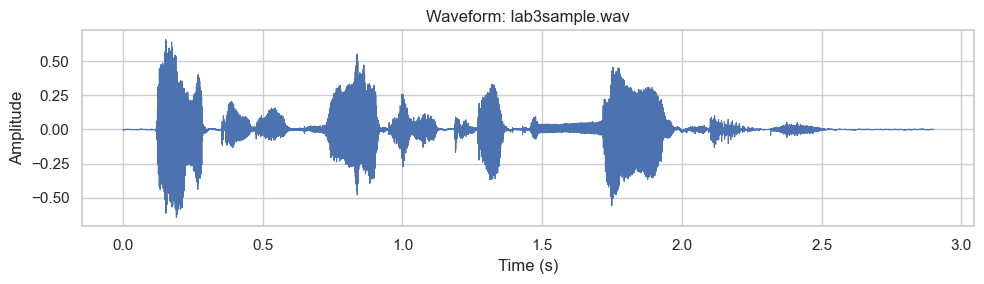

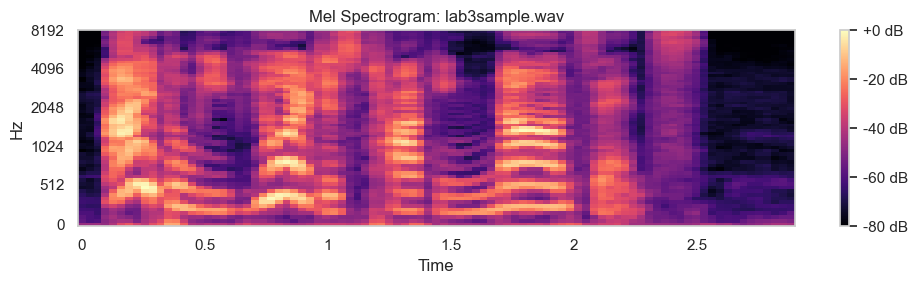

Running single-file test...
Loading Whisper model (this may take a moment)...
✓ Whisper model loaded successfully

⚙️ Processing audio file...
✓ Audio file loaded successfully: lab3sample.wav


SPEECH RECOGNITION RESULTS

1️⃣  Google Speech Recognition API (Online)
------------------------------------------------------------
🔄 Recognizing...
✅ Speech successfully converted to text!
Result: I believe you are just talking nonsense

2️⃣  OpenAI Whisper (Offline)
------------------------------------------------------------
🔄 Recognizing...
✅ Speech successfully converted to text!
Result: I believe you're just talking nonsense.

3️⃣  Vosk (Offline)
------------------------------------------------------------
🔄 Recognizing...


LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=10 max-active=3000 lattice-beam=2
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 0 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 0 orphan components.
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from vosk-model-small-en-us-0.15/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:282) Loading HCL and G from vosk-model-small-en-us-0.15/graph/HCLr.fst vosk-model-small-en-us-0.15/graph/Gr.fst
LOG (VoskAPI:ReadDataFiles():model.cc:303) Loading winfo vosk-model-small-en-us-0.15/graph/phones/word_boundary.int


✅ Speech successfully converted to text!
Result: i believe you're just talking nonsense

4️⃣  CMU Sphinx (Offline)
------------------------------------------------------------
🔄 Recognizing...
✅ Speech successfully converted to text!
Result: i believe you would just talking nonsense



Transcripts:
- Google API: I believe you are just talking nonsense
- Whisper: I believe you're just talking nonsense.
- Vosk: i believe you're just talking nonsense
- Sphinx: i believe you would just talking nonsense


In [ ]:
# SECTION 3.2: Ready-to-run demo cells (set paths, visualize, compare)
from IPython.display import Audio, display

# Example: set your audio file here (or use upload_audio_files())
audio_file = "lab3sample.wav"  # or replace with uploaded/Drive path

# Optional: reference transcripts for WER
references = {
    # 'Clear male voice': 'expected transcript here',
}

# Visualize audio
if os.path.exists(audio_file):
    plot_waveform(audio_file)
    plot_spectrogram(audio_file)
    display(Audio(filename=audio_file))
else:
    print(f"Audio not found at {audio_file}. Use upload_audio_files() or provide a valid path.")

# Single-file run
if os.path.exists(audio_file):
    print("Running single-file test...")
    stt = SpeechToTextSystem()
    out = process_and_measure(stt, audio_file, None)
    print("\nTranscripts:")
    for k, v in out['results'].items():
        print(f"- {k}: {v}")
else:
    print("Skipping single-file test due to missing audio.")


In [30]:
# SECTION 3.3: Create and Save Comparison Table (run this cell)
from IPython.display import display

# Define your scenarios here. Start with one to confirm it works.
# You can add more labeled scenarios pointing to different files.
test_scenarios = {}

# Prefer the earlier audio_file if set; otherwise prompt upload in Colab
if 'audio_file' in globals() and isinstance(audio_file, str) and os.path.exists(audio_file):
    test_scenarios['Sample audio'] = audio_file
else:
    if IN_COLAB:
        uploaded = upload_audio_files("Upload at least one .wav/.flac to build the table")
        if uploaded:
            # Pick first uploaded as sample; you can add more below
            first_name = next(iter(uploaded))
            test_scenarios['Uploaded sample'] = uploaded[first_name]
    else:
        print("No valid 'audio_file' found. Please set 'audio_file' to a valid path or run in Colab and upload.")

if test_scenarios:
    print("Building comparison table...")
    df = run_comparison(test_scenarios, references)
    csv_path = 'speech_recognition_comparison.csv'
    df.to_csv(csv_path, index=False)
    print(f"\n✅ Saved comparison table to {csv_path}")
    display(df)
else:
    print("❌ No scenarios defined. Please set 'audio_file' or upload files in Colab.")


Building comparison table...
Loading Whisper model (this may take a moment)...
✓ Whisper model loaded successfully


📊 Testing: Sample audio
------------------------------------------------------------
⚙️ Processing audio file...
✓ Audio file loaded successfully: lab3sample.wav


SPEECH RECOGNITION RESULTS

1️⃣  Google Speech Recognition API (Online)
------------------------------------------------------------
🔄 Recognizing...
✅ Speech successfully converted to text!
Result: I believe you are just talking nonsense

2️⃣  OpenAI Whisper (Offline)
------------------------------------------------------------
🔄 Recognizing...
✅ Speech successfully converted to text!
Result: I believe you're just talking nonsense.

3️⃣  Vosk (Offline)
------------------------------------------------------------
🔄 Recognizing...


LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=10 max-active=3000 lattice-beam=2
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 0 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 0 orphan components.
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from vosk-model-small-en-us-0.15/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:282) Loading HCL and G from vosk-model-small-en-us-0.15/graph/HCLr.fst vosk-model-small-en-us-0.15/graph/Gr.fst
LOG (VoskAPI:ReadDataFiles():model.cc:303) Loading winfo vosk-model-small-en-us-0.15/graph/phones/word_boundary.int


✅ Speech successfully converted to text!
Result: i believe you're just talking nonsense

4️⃣  CMU Sphinx (Offline)
------------------------------------------------------------
🔄 Recognizing...
✅ Speech successfully converted to text!
Result: i believe you would just talking nonsense




,Audio Type,Whisper Output,Vosk Output,Google API Output,Sphinx Output
0,Sample audio,I believe you're just talking nonsense.,i believe you're just talking nonsense,I believe you are just talking nonsense,i believe you would just talking nonsense



✅ Saved comparison table to speech_recognition_comparison.csv


,Audio Type,Whisper Output,Vosk Output,Google API Output,Sphinx Output
0,Sample audio,I believe you're just talking nonsense.,i believe you're just talking nonsense,I believe you are just talking nonsense,i believe you would just talking nonsense


In [32]:
# Simplified Speech-to-Text Application for Accessibility
# Lab Exercise 3
# Processes high_pitch.wav and calm.mp3 from audio_files folder

import speech_recognition as sr
import os
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

# Try importing optional libraries
try:
    import whisper
    WHISPER_AVAILABLE = True
    print("✓ Whisper available")
except ImportError:
    WHISPER_AVAILABLE = False
    print("⚠ Whisper not available (install: pip install openai-whisper)")

try:
    from vosk import Model, KaldiRecognizer
    import wave
    import json
    VOSK_AVAILABLE = True
    print("✓ Vosk available")
except ImportError:
    VOSK_AVAILABLE = False
    print("⚠ Vosk not available (install: pip install vosk)")

try:
    from pydub import AudioSegment
    PYDUB_AVAILABLE = True
    print("✓ Pydub available")
except ImportError:
    PYDUB_AVAILABLE = False
    print("⚠ Pydub not available (install: pip install pydub)")

class SimpleSpeechToText:
    def __init__(self):
        self.recognizer = sr.Recognizer()
        self.whisper_model = whisper.load_model("base") if WHISPER_AVAILABLE else None
        self.vosk_model_path = "vosk-model-small-en-us-0.15"

    def show_feedback(self, message):
        print(f"ℹ️ {message}")

    def convert_to_wav(self, file_path):
        """Convert mp3 to wav if necessary, return wav path."""
        if not PYDUB_AVAILABLE and file_path.endswith('.mp3'):
            return None, "Error: Pydub required for mp3 files (install: pip install pydub)"
        if file_path.endswith('.wav'):
            return file_path, None
        try:
            audio = AudioSegment.from_mp3(file_path)
            wav_path = file_path.replace('.mp3', '.wav')
            audio.export(wav_path, format='wav')
            return wav_path, None
        except Exception as e:
            return None, f"Error converting mp3 to wav: {e}"

    def load_audio_file(self, file_path):
        self.show_feedback("Loading audio file...")
        try:
            if not os.path.exists(file_path):
                self.show_feedback(f"File not found: {file_path}")
                return None
            # Convert mp3 to wav if necessary
            if file_path.endswith('.mp3'):
                wav_path, error = self.convert_to_wav(file_path)
                if error:
                    self.show_feedback(error)
                    return None
                file_path = wav_path
            with sr.AudioFile(file_path) as source:
                audio = self.recognizer.record(source)
                self.show_feedback("Audio file loaded")
                return audio
        except Exception as e:
            self.show_feedback(f"Error loading audio: {e}")
            return None

    def google_recognize(self, audio):
        self.show_feedback("Recognizing with Google API...")
        try:
            text = self.recognizer.recognize_google(audio)
            self.show_feedback("Speech successfully converted to text!")
            return f"Speech recognized: '{text}'"
        except sr.UnknownValueError:
            return "Error: Could not understand audio. Please speak clearly."
        except sr.RequestError as e:
            return f"Error: Google API unavailable. Check internet. ({e})"
        except Exception as e:
            return f"Error in Google recognition: {e}"

    def whisper_recognize(self, file_path):
        if not WHISPER_AVAILABLE or not self.whisper_model:
            return "Error: Whisper not available (install: pip install openai-whisper)"
        self.show_feedback("Recognizing with Whisper...")
        try:
            # Convert mp3 to wav if necessary
            if file_path.endswith('.mp3'):
                file_path, error = self.convert_to_wav(file_path)
                if error:
                    return error
            if not os.path.exists(file_path):
                return "Error: Audio file not found"
            result = self.whisper_model.transcribe(file_path)
            text = result["text"].strip()
            self.show_feedback("Speech successfully converted to text!")
            return f"Speech recognized: '{text}'"
        except Exception as e:
            return f"Error in Whisper recognition: {e}"

    def vosk_recognize(self, file_path):
        if not VOSK_AVAILABLE:
            return "Error: Vosk not available (install: pip install vosk)"
        if not os.path.exists(self.vosk_model_path):
            return "Error: Vosk model not found. Download from https://alphacephei.com/vosk/models"
        self.show_feedback("Recognizing with Vosk...")
        try:
            # Convert mp3 to wav if necessary
            if file_path.endswith('.mp3'):
                file_path, error = self.convert_to_wav(file_path)
                if error:
                    return error
            wf = wave.open(file_path, "rb")
            if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getcomptype() != "NONE":
                return "Error: Audio must be WAV mono PCM"
            model = Model(self.vosk_model_path)
            rec = KaldiRecognizer(model, wf.getframerate())
            results = []
            while True:
                data = wf.readframes(4000)
                if len(data) == 0:
                    break
                if rec.AcceptWaveform(data):
                    result = json.loads(rec.Result())
                    if 'text' in result:
                        results.append(result['text'])
            final_result = json.loads(rec.FinalResult())
            if 'text' in final_result:
                results.append(final_result['text'])
            text = ' '.join(results).strip()
            wf.close()
            self.show_feedback("Speech successfully converted to text!")
            return f"Speech recognized: '{text}'" if text else "Error: No speech detected"
        except Exception as e:
            return f"Error in Vosk recognition: {e}"

    def process_audio(self, source, source_type='file'):
        results = {'Google API': 'N/A', 'Whisper': 'N/A', 'Vosk': 'N/A'}
        audio_file_path = source if source_type == 'file' else None
        audio_data = self.load_audio_file(source) if source_type == 'file' else source

        print("\n=== Speech Recognition Results ===")
        if audio_data:
            results['Google API'] = self.google_recognize(audio_data)
            print(f"Google API: {results['Google API']}")
        if audio_file_path:
            results['Whisper'] = self.whisper_recognize(audio_file_path)
            print(f"Whisper: {results['Whisper']}")
            results['Vosk'] = self.vosk_recognize(audio_file_path)
            print(f"Vosk: {results['Vosk']}")
        else:
            print("Whisper and Vosk require audio file path")
        print("=================================\n")
        return results

def create_comparison_table():
    import pandas as pd
    test_scenarios = {
        'High Pitch Voice': 'audio_files/high_pitch.wav',
        'Calm Voice': 'audio_files/calm.mp3'
    }
    comparison_data = []
    stt = SimpleSpeechToText()
    
    for audio_type, file_path in test_scenarios.items():
        print(f"\nTesting: {audio_type}")
        results = stt.process_audio(file_path, source_type='file')
        comparison_data.append({
            'Audio Type': audio_type,
            'Google API': results['Google API'],
            'Whisper': results['Whisper'],
            'Vosk': results['Vosk'],
            'Notes': ''
        })
    
    df = pd.DataFrame(comparison_data)
    print("\n=== Comparison Table ===")
    print(df.to_string(index=False))
    df.to_csv('speech_comparison.csv', index=False)
    print("Table saved to 'speech_comparison.csv'")
    return df

if __name__ == "__main__":
    print("\n=== Speech-to-Text System ===")
    
    # Test both audio files and create comparison table
    create_comparison_table()
    
    print("\n=== Testing Completed ===")

"""
INSTRUCTIONS:
1. Install dependencies:
   pip install speechrecognition openai-whisper vosk pyaudio pydub
   Download Vosk model: https://alphacephei.com/vosk/models
   Ensure ffmpeg is installed for pydub (mp3 support)

2. File setup:
   Ensure high_pitch.wav and calm.mp3 are in the 'audio_files' folder
   Paths are set to 'audio_files/high_pitch.wav' and 'audio_files/calm.mp3'

3. Running the script:
   Run the script to process both audio files and generate comparison table
   Results are saved to 'speech_comparison.csv'

4. Troubleshooting:
   - Check internet for Google API
   - Verify Vosk model path
   - Ensure audio_files folder exists with both files
   - Install ffmpeg for mp3 support (pydub requirement)
"""

✓ Whisper available
✓ Vosk available
✓ Pydub available

=== Speech-to-Text System ===

Testing: High Pitch Voice
ℹ️ Loading audio file...
ℹ️ Audio file loaded

=== Speech Recognition Results ===
ℹ️ Recognizing with Google API...
ℹ️ Speech successfully converted to text!
Google API: Speech recognized: 'I believe you are just talking nonsense'
ℹ️ Recognizing with Whisper...
ℹ️ Speech successfully converted to text!
Whisper: Speech recognized: 'I believe you're just talking nonsense.'
ℹ️ Recognizing with Vosk...


LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=10 max-active=3000 lattice-beam=2
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 0 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 0 orphan components.
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from vosk-model-small-en-us-0.15/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:282) Loading HCL and G from vosk-model-small-en-us-0.15/graph/HCLr.fst vosk-model-small-en-us-0.15/graph/Gr.fst
LOG (VoskAPI:ReadDataFiles():model.cc:303) Loading winfo vosk-model-small-en-us-0.15/graph/phones/word_boundary.int


ℹ️ Speech successfully converted to text!
Vosk: Speech recognized: 'i believe you're just talking nonsense'


Testing: Calm Voice
ℹ️ Loading audio file...
ℹ️ Audio file loaded

=== Speech Recognition Results ===
ℹ️ Recognizing with Google API...
ℹ️ Speech successfully converted to text!
Google API: Speech recognized: 'faster diagnosis personalized treatment plants and improved patient outcomes'
ℹ️ Recognizing with Whisper...
ℹ️ Speech successfully converted to text!
Whisper: Speech recognized: 'faster diagnosis, personalized treatment plans, and improved patient outcomes.'
ℹ️ Recognizing with Vosk...


LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=10 max-active=3000 lattice-beam=2
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 0 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 0 orphan components.
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from vosk-model-small-en-us-0.15/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:282) Loading HCL and G from vosk-model-small-en-us-0.15/graph/HCLr.fst vosk-model-small-en-us-0.15/graph/Gr.fst
LOG (VoskAPI:ReadDataFiles():model.cc:303) Loading winfo vosk-model-small-en-us-0.15/graph/phones/word_boundary.int


ℹ️ Speech successfully converted to text!
Vosk: Speech recognized: 'foster diagnosis personalized treatment plans and improved patient outcomes'


=== Comparison Table ===
      Audio Type                                                                                        Google API                                                                                             Whisper                                                                                             Vosk Notes
High Pitch Voice                                      Speech recognized: 'I believe you are just talking nonsense'                                        Speech recognized: 'I believe you're just talking nonsense.'                                      Speech recognized: 'i believe you're just talking nonsense'      
      Calm Voice Speech recognized: 'faster diagnosis personalized treatment plants and improved patient outcomes' Speech recognized: 'faster diagnosis, personalized treatment plans, and impro

"\nINSTRUCTIONS:\n1. Install dependencies:\n   pip install speechrecognition openai-whisper vosk pyaudio pydub\n   Download Vosk model: https://alphacephei.com/vosk/models\n   Ensure ffmpeg is installed for pydub (mp3 support)\n\n2. File setup:\n   Ensure high_pitch.wav and calm.mp3 are in the 'audio_files' folder\n   Paths are set to 'audio_files/high_pitch.wav' and 'audio_files/calm.mp3'\n\n3. Running the script:\n   Run the script to process both audio files and generate comparison table\n   Results are saved to 'speech_comparison.csv'\n\n4. Troubleshooting:\n   - Check internet for Google API\n   - Verify Vosk model path\n   - Ensure audio_files folder exists with both files\n   - Install ffmpeg for mp3 support (pydub requirement)\n"

In [ ]:
# Simplified Speech-to-Text Application for Accessibility with Visualizations
# Lab Exercise 3
# Processes high_pitch.wav and calm.mp3 from audio_files folder

import speech_recognition as sr
import os
import warnings
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
warnings.filterwarnings('ignore')

# Try importing optional libraries
try:
    import whisper
    WHISPER_AVAILABLE = True
    print("✓ Whisper available")
except ImportError:
    WHISPER_AVAILABLE = False
    print("⚠ Whisper not available (install: pip install openai-whisper)")

try:
    from vosk import Model, KaldiRecognizer
    import wave
    import json
    VOSK_AVAILABLE = True
    print("✓ Vosk available")
except ImportError:
    VOSK_AVAILABLE = False
    print("⚠ Vosk not available (install: pip install vosk)")

try:
    from pydub import AudioSegment
    PYDUB_AVAILABLE = True
    print("✓ Pydub available")
except ImportError:
    PYDUB_AVAILABLE = False
    print("⚠ Pydub not available (install: pip install pydub)")

class SimpleSpeechToText:
    def __init__(self):
        self.recognizer = sr.Recognizer()
        self.whisper_model = whisper.load_model("base") if WHISPER_AVAILABLE else None
        self.vosk_model_path = "vosk-model-small-en-us-0.15"

    def show_feedback(self, message):
        print(f"ℹ️ {message}")

    def convert_to_wav(self, file_path):
        """Convert mp3 to wav if necessary, return wav path."""
        if not PYDUB_AVAILABLE and file_path.endswith('.mp3'):
            return None, "Error: Pydub required for mp3 files (install: pip install pydub)"
        if file_path.endswith('.wav'):
            return file_path, None
        try:
            audio = AudioSegment.from_mp3(file_path)
            wav_path = file_path.replace('.mp3', '.wav')
            audio.export(wav_path, format='wav')
            return wav_path, None
        except Exception as e:
            return None, f"Error converting mp3 to wav: {e}"

    def load_audio_file(self, file_path):
        self.show_feedback("Loading audio file...")
        try:
            if not os.path.exists(file_path):
                self.show_feedback(f"File not found: {file_path}")
                return None
            if file_path.endswith('.mp3'):
                wav_path, error = self.convert_to_wav(file_path)
                if error:
                    self.show_feedback(error)
                    return None
                file_path = wav_path
            with sr.AudioFile(file_path) as source:
                audio = self.recognizer.record(source)
                self.show_feedback("Audio file loaded")
                return audio
        except Exception as e:
            self.show_feedback(f"Error loading audio: {e}")
            return None

    def google_recognize(self, audio):
        self.show_feedback("Recognizing with Google API...")
        try:
            text = self.recognizer.recognize_google(audio)
            self.show_feedback("Speech successfully converted to text!")
            return f"Speech recognized: '{text}'"
        except sr.UnknownValueError:
            return "Error: Could not understand audio. Please speak clearly."
        except sr.RequestError as e:
            return f"Error: Google API unavailable. Check internet. ({e})"
        except Exception as e:
            return f"Error in Google recognition: {e}"

    def whisper_recognize(self, file_path):
        if not WHISPER_AVAILABLE or not self.whisper_model:
            return "Error: Whisper not available (install: pip install openai-whisper)"
        self.show_feedback("Recognizing with Whisper...")
        try:
            if file_path.endswith('.mp3'):
                file_path, error = self.convert_to_wav(file_path)
                if error:
                    return error
            if not os.path.exists(file_path):
                return "Error: Audio file not found"
            result = self.whisper_model.transcribe(file_path)
            text = result["text"].strip()
            self.show_feedback("Speech successfully converted to text!")
            return f"Speech recognized: '{text}'"
        except Exception as e:
            return f"Error in Whisper recognition: {e}"

    def vosk_recognize(self, file_path):
        if not VOSK_AVAILABLE:
            return "Error: Vosk not available (install: pip install vosk)"
        if not os.path.exists(self.vosk_model_path):
            return "Error: Vosk model not found. Download from https://alphacephei.com/vosk/models"
        self.show_feedback("Recognizing with Vosk...")
        try:
            if file_path.endswith('.mp3'):
                file_path, error = self.convert_to_wav(file_path)
                if error:
                    return error
            wf = wave.open(file_path, "rb")
            if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getcomptype() != "NONE":
                return "Error: Audio must be WAV mono PCM"
            model = Model(self.vosk_model_path)
            rec = KaldiRecognizer(model, wf.getframerate())
            results = []
            while True:
                data = wf.readframes(4000)
                if len(data) == 0:
                    break
                if rec.AcceptWaveform(data):
                    result = json.loads(rec.Result())
                    if 'text' in result:
                        results.append(result['text'])
            final_result = json.loads(rec.FinalResult())
            if 'text' in final_result:
                results.append(final_result['text'])
            text = ' '.join(results).strip()
            wf.close()
            self.show_feedback("Speech successfully converted to text!")
            return f"Speech recognized: '{text}'" if text else "Error: No speech detected"
        except Exception as e:
            return f"Error in Vosk recognition: {e}"

    def process_audio(self, source, source_type='file'):
        results = {'Google API': 'N/A', 'Whisper': 'N/A', 'Vosk': 'N/A'}
        audio_file_path = source if source_type == 'file' else None
        audio_data = self.load_audio_file(source) if source_type == 'file' else source

        print("\n=== Speech Recognition Results ===")
        if audio_data:
            results['Google API'] = self.google_recognize(audio_data)
            print(f"Google API: {results['Google API']}")
        if audio_file_path:
            results['Whisper'] = self.whisper_recognize(audio_file_path)
            print(f"Whisper: {results['Whisper']}")
            results['Vosk'] = self.vosk_recognize(audio_file_path)
            print(f"Vosk: {results['Vosk']}")
        else:
            print("Whisper and Vosk require audio file path")
        print("=================================\n")
        return results

def create_visualizations(comparison_data):
    """Generate visualizations for comparison data."""
    # Bar Plot: Text length by method and audio type
    methods = ['Google API', 'Whisper', 'Vosk']
    audio_types = [row['Audio Type'] for row in comparison_data]
    lengths = {method: [] for method in methods}
    
    for row in comparison_data:
        for method in methods:
            text = row[method]
            length = len(text.replace("Speech recognized: ", "").strip("'")) if text.startswith("Speech recognized") else 0
            lengths[method].append(length)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.25
    x = range(len(audio_types))
    for i, method in enumerate(methods):
        ax.bar([pos + i * bar_width for pos in x], lengths[method], bar_width, label=method)
    
    ax.set_xlabel('Audio Type')
    ax.set_ylabel('Recognized Text Length (characters)')
    ax.set_title('Text Length by Recognition Method')
    ax.set_xticks([pos + bar_width for pos in x])
    ax.set_xticklabels(audio_types)
    ax.legend()
    plt.tight_layout()
    plt.savefig('text_length_comparison.png')
    plt.close()
    print("✓ Bar plot saved as 'text_length_comparison.png'")

    # Word Cloud: Combined text for each audio type
    for row in comparison_data:
        audio_type = row['Audio Type']
        combined_text = ' '.join([
            row[method].replace("Speech recognized: ", "").strip("'")
            for method in methods if row[method].startswith("Speech recognized")
        ])
        if combined_text.strip():
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f"Word Cloud for {audio_type}")
            plt.savefig(f'wordcloud_{audio_type.replace(" ", "_").lower()}.png')
            plt.close()
            print(f"✓ Word cloud saved as 'wordcloud_{audio_type.replace(' ', '_').lower()}.png'")

def create_comparison_table():
    import pandas as pd
    test_scenarios = {
        'High Pitch Voice': 'audio_files/high_pitch.wav',
        'Calm Voice': 'audio_files/calm.mp3'
    }
    comparison_data = []
    stt = SimpleSpeechToText()
    
    for audio_type, file_path in test_scenarios.items():
        print(f"\nTesting: {audio_type}")
        results = stt.process_audio(file_path, source_type='file')
        comparison_data.append({
            'Audio Type': audio_type,
            'Google API': results['Google API'],
            'Whisper': results['Whisper'],
            'Vosk': results['Vosk'],
            'Notes': ''
        })
    
    df = pd.DataFrame(comparison_data)
    print("\n=== Comparison Table ===")
    print(df.to_string(index=False, col_space=15, justify='left'))
    df.to_csv('speech_comparison.csv', index=False)
    print("✓ Table saved to 'speech_comparison.csv'")
    
    # Generate visualizations
    create_visualizations(comparison_data)
    return df

if __name__ == "__main__":
    print("\n=== Speech-to-Text System ===")
    create_comparison_table()
    print("\n=== Testing Completed ===")

✓ Whisper available
✓ Vosk available
✓ Pydub available

=== Speech-to-Text System ===

Testing: High Pitch Voice
ℹ️ Loading audio file...
ℹ️ Audio file loaded

=== Speech Recognition Results ===
ℹ️ Recognizing with Google API...
ℹ️ Speech successfully converted to text!
Google API: Speech recognized: 'I believe you are just talking nonsense'
ℹ️ Recognizing with Whisper...
ℹ️ Speech successfully converted to text!
Whisper: Speech recognized: 'I believe you're just talking nonsense.'
ℹ️ Recognizing with Vosk...


LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=10 max-active=3000 lattice-beam=2
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 0 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 0 orphan components.
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from vosk-model-small-en-us-0.15/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:282) Loading HCL and G from vosk-model-small-en-us-0.15/graph/HCLr.fst vosk-model-small-en-us-0.15/graph/Gr.fst
LOG (VoskAPI:ReadDataFiles():model.cc:303) Loading winfo vosk-model-small-en-us-0.15/graph/phones/word_boundary.int


ℹ️ Speech successfully converted to text!
Vosk: Speech recognized: 'i believe you're just talking nonsense'


Testing: Calm Voice
ℹ️ Loading audio file...
ℹ️ Audio file loaded

=== Speech Recognition Results ===
ℹ️ Recognizing with Google API...
ℹ️ Speech successfully converted to text!
Google API: Speech recognized: 'faster diagnosis personalized treatment plants and improved patient outcomes'
ℹ️ Recognizing with Whisper...
ℹ️ Speech successfully converted to text!
Whisper: Speech recognized: 'faster diagnosis, personalized treatment plans, and improved patient outcomes.'
ℹ️ Recognizing with Vosk...


LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=10 max-active=3000 lattice-beam=2
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 0 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 0 orphan components.
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from vosk-model-small-en-us-0.15/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:282) Loading HCL and G from vosk-model-small-en-us-0.15/graph/HCLr.fst vosk-model-small-en-us-0.15/graph/Gr.fst
LOG (VoskAPI:ReadDataFiles():model.cc:303) Loading winfo vosk-model-small-en-us-0.15/graph/phones/word_boundary.int


ℹ️ Speech successfully converted to text!
Vosk: Speech recognized: 'foster diagnosis personalized treatment plans and improved patient outcomes'


=== Comparison Table ===
Audio Type       Google API                                                                                        Whisper                                                                                             Vosk                                                                                             Notes          
High Pitch Voice                                      Speech recognized: 'I believe you are just talking nonsense'                                        Speech recognized: 'I believe you're just talking nonsense.'                                      Speech recognized: 'i believe you're just talking nonsense'                
      Calm Voice Speech recognized: 'faster diagnosis personalized treatment plants and improved patient outcomes' Speech recognized: 'faster diagnosis, personalized treatm

"\nINSTRUCTIONS:\n1. Install dependencies:\n   pip install speechrecognition openai-whisper vosk pyaudio pydub matplotlib wordcloud\n   Download Vosk model: https://alphacephei.com/vosk/models\n   Ensure ffmpeg is installed for pydub (mp3 support)\n\n2. File setup:\n   Ensure high_pitch.wav and calm.mp3 are in the 'audio_files' folder\n   Paths are set to 'audio_files/high_pitch.wav' and 'audio_files/calm.mp3'\n\n3. Running the script:\n   Run to process both audio files, generate comparison table, and create visualizations\n   Results saved to 'speech_comparison.csv'\n   Visualizations saved as 'text_length_comparison.png' and 'wordcloud_*.png'\n\n4. Troubleshooting:\n   - Check internet for Google API\n   - Verify Vosk model path\n   - Ensure audio_files folder exists with both files\n   - Install ffmpeg for mp3 support\n"

✓ Whisper available
✓ Vosk available
✓ Pydub available
✓ Visualization libraries available

=== Speech-to-Text System ===

Testing: High Pitch Voice
ℹ️ Loading audio file...
ℹ️ Audio file loaded

=== Speech Recognition Results ===
ℹ️ Recognizing with Google API...
ℹ️ Speech successfully converted to text!
Google API: Speech recognized: 'I believe you are just talking nonsense'
ℹ️ Recognizing with Whisper...
ℹ️ Speech successfully converted to text!
Whisper: Speech recognized: 'I believe you're just talking nonsense.'
ℹ️ Recognizing with Vosk...


LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=10 max-active=3000 lattice-beam=2
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 0 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 0 orphan components.
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from vosk-model-small-en-us-0.15/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:282) Loading HCL and G from vosk-model-small-en-us-0.15/graph/HCLr.fst vosk-model-small-en-us-0.15/graph/Gr.fst
LOG (VoskAPI:ReadDataFiles():model.cc:303) Loading winfo vosk-model-small-en-us-0.15/graph/phones/word_boundary.int


ℹ️ Speech successfully converted to text!
Vosk: Speech recognized: 'i believe you're just talking nonsense'


Testing: Calm Voice
ℹ️ Loading audio file...
ℹ️ Audio file loaded

=== Speech Recognition Results ===
ℹ️ Recognizing with Google API...
ℹ️ Speech successfully converted to text!
Google API: Speech recognized: 'faster diagnosis personalized treatment plants and improved patient outcomes'
ℹ️ Recognizing with Whisper...
ℹ️ Speech successfully converted to text!
Whisper: Speech recognized: 'faster diagnosis, personalized treatment plans, and improved patient outcomes.'
ℹ️ Recognizing with Vosk...


LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=10 max-active=3000 lattice-beam=2
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 0 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 0 orphan components.
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from vosk-model-small-en-us-0.15/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:282) Loading HCL and G from vosk-model-small-en-us-0.15/graph/HCLr.fst vosk-model-small-en-us-0.15/graph/Gr.fst
LOG (VoskAPI:ReadDataFiles():model.cc:303) Loading winfo vosk-model-small-en-us-0.15/graph/phones/word_boundary.int


ℹ️ Speech successfully converted to text!
Vosk: Speech recognized: 'foster diagnosis personalized treatment plans and improved patient outcomes'


=== Comparison Table ===
Audio Type       Google API                                                                                        Whisper                                                                                             Vosk                                                                                             Notes               
High Pitch Voice                                      Speech recognized: 'I believe you are just talking nonsense'                                        Speech recognized: 'I believe you're just talking nonsense.'                                      Speech recognized: 'i believe you're just talking nonsense'                     
      Calm Voice Speech recognized: 'faster diagnosis personalized treatment plants and improved patient outcomes' Speech recognized: 'faster diagnosis, personali

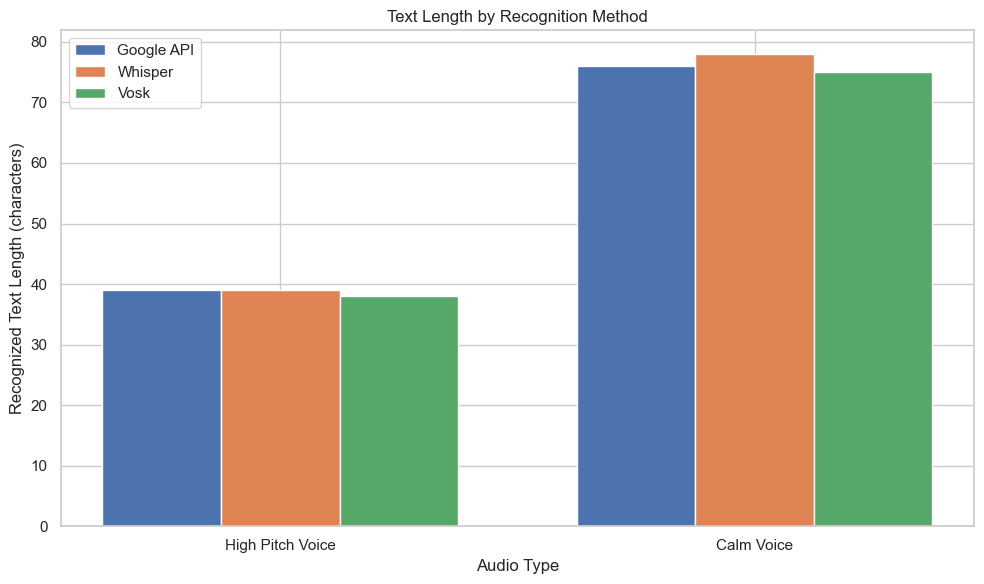

✓ Bar plot saved as 'text_length_comparison.png'


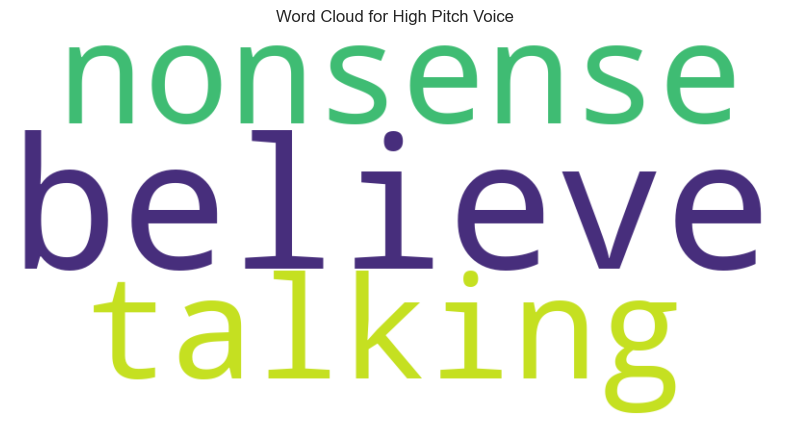

✓ Word cloud saved as 'wordcloud_high_pitch_voice.png'


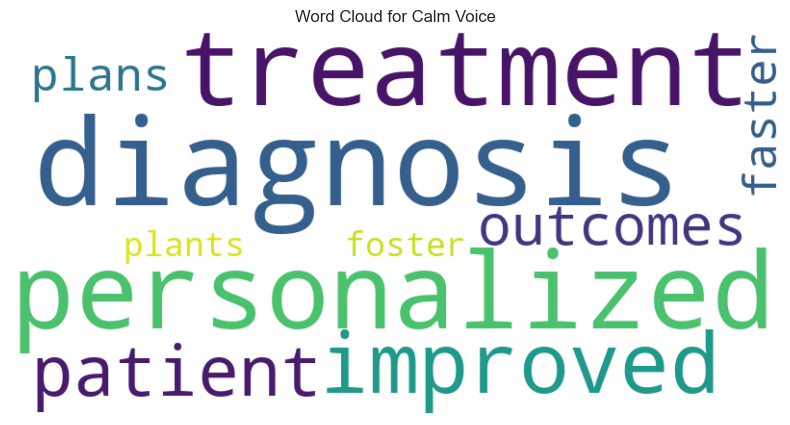

✓ Word cloud saved as 'wordcloud_calm_voice.png'

=== Testing Completed ===


"\nINSTRUCTIONS:\n1. Install dependencies:\n   pip install speechrecognition openai-whisper vosk pyaudio pydub matplotlib wordcloud\n   Download Vosk model: https://alphacephei.com/vosk/models\n   Ensure ffmpeg is installed for pydub (mp3 support)\n\n2. File setup:\n   Ensure high_pitch.wav and calm.mp3 are in the 'audio_files' folder\n   Paths are set to 'audio_files/high_pitch.wav' and 'audio_files/calm.mp3'\n\n3. Running the script:\n   Run to process both audio files, generate comparison table, and display/save visualizations\n   Results saved to 'speech_comparison.csv'\n   Visualizations saved as 'text_length_comparison.png' and 'wordcloud_*.png'\n   Graphs will display interactively if run in Jupyter or VS Code\n\n4. Troubleshooting:\n   - Check internet for Google API\n   - Verify Vosk model path\n   - Ensure audio_files folder exists with both files\n   - Install ffmpeg for mp3 support\n   - Ensure matplotlib and wordcloud are installed for visualizations\n"

In [36]:
# Simplified Speech-to-Text Application for Accessibility with Visualizations
# Lab Exercise 3
# Processes high_pitch.wav and calm.mp3 from audio_files folder

import speech_recognition as sr
import os
import warnings
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
warnings.filterwarnings('ignore')

# Try importing optional libraries
try:
    import whisper
    WHISPER_AVAILABLE = True
    print("✓ Whisper available")
except ImportError:
    WHISPER_AVAILABLE = False
    print("⚠ Whisper not available (install: pip install openai-whisper)")

try:
    from vosk import Model, KaldiRecognizer
    import wave
    import json
    VOSK_AVAILABLE = True
    print("✓ Vosk available")
except ImportError:
    VOSK_AVAILABLE = False
    print("⚠ Vosk not available (install: pip install vosk)")

try:
    from pydub import AudioSegment
    PYDUB_AVAILABLE = True
    print("✓ Pydub available")
except ImportError:
    PYDUB_AVAILABLE = False
    print("⚠ Pydub not available (install: pip install pydub)")

try:
    import matplotlib.pyplot as plt
    import wordcloud
    VISUALIZATION_AVAILABLE = True
    print("✓ Visualization libraries available")
except ImportError:
    VISUALIZATION_AVAILABLE = False
    print("⚠ Visualization libraries not available (install: pip install matplotlib wordcloud)")

class SimpleSpeechToText:
    def __init__(self):
        self.recognizer = sr.Recognizer()
        self.whisper_model = whisper.load_model("base") if WHISPER_AVAILABLE else None
        self.vosk_model_path = "vosk-model-small-en-us-0.15"

    def show_feedback(self, message):
        print(f"ℹ️ {message}")

    def convert_to_wav(self, file_path):
        """Convert mp3 to wav if necessary, return wav path."""
        if not PYDUB_AVAILABLE and file_path.endswith('.mp3'):
            return None, "Error: Pydub required for mp3 files (install: pip install pydub)"
        if file_path.endswith('.wav'):
            return file_path, None
        try:
            audio = AudioSegment.from_mp3(file_path)
            wav_path = file_path.replace('.mp3', '.wav')
            audio.export(wav_path, format='wav')
            return wav_path, None
        except Exception as e:
            return None, f"Error converting mp3 to wav: {e}"

    def load_audio_file(self, file_path):
        self.show_feedback("Loading audio file...")
        try:
            if not os.path.exists(file_path):
                self.show_feedback(f"File not found: {file_path}")
                return None
            if file_path.endswith('.mp3'):
                wav_path, error = self.convert_to_wav(file_path)
                if error:
                    self.show_feedback(error)
                    return None
                file_path = wav_path
            with sr.AudioFile(file_path) as source:
                audio = self.recognizer.record(source)
                self.show_feedback("Audio file loaded")
                return audio
        except Exception as e:
            self.show_feedback(f"Error loading audio: {e}")
            return None

    def google_recognize(self, audio):
        self.show_feedback("Recognizing with Google API...")
        try:
            text = self.recognizer.recognize_google(audio)
            self.show_feedback("Speech successfully converted to text!")
            return f"Speech recognized: '{text}'"
        except sr.UnknownValueError:
            return "Error: Could not understand audio. Please speak clearly."
        except sr.RequestError as e:
            return f"Error: Google API unavailable. Check internet. ({e})"
        except Exception as e:
            return f"Error in Google recognition: {e}"

    def whisper_recognize(self, file_path):
        if not WHISPER_AVAILABLE or not self.whisper_model:
            return "Error: Whisper not available (install: pip install openai-whisper)"
        self.show_feedback("Recognizing with Whisper...")
        try:
            if file_path.endswith('.mp3'):
                file_path, error = self.convert_to_wav(file_path)
                if error:
                    return error
            if not os.path.exists(file_path):
                return "Error: Audio file not found"
            result = self.whisper_model.transcribe(file_path)
            text = result["text"].strip()
            self.show_feedback("Speech successfully converted to text!")
            return f"Speech recognized: '{text}'"
        except Exception as e:
            return f"Error in Whisper recognition: {e}"

    def vosk_recognize(self, file_path):
        if not VOSK_AVAILABLE:
            return "Error: Vosk not available (install: pip install vosk)"
        if not os.path.exists(self.vosk_model_path):
            return "Error: Vosk model not found. Download from https://alphacephei.com/vosk/models"
        self.show_feedback("Recognizing with Vosk...")
        try:
            if file_path.endswith('.mp3'):
                file_path, error = self.convert_to_wav(file_path)
                if error:
                    return error
            wf = wave.open(file_path, "rb")
            if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getcomptype() != "NONE":
                return "Error: Audio must be WAV mono PCM"
            model = Model(self.vosk_model_path)
            rec = KaldiRecognizer(model, wf.getframerate())
            results = []
            while True:
                data = wf.readframes(4000)
                if len(data) == 0:
                    break
                if rec.AcceptWaveform(data):
                    result = json.loads(rec.Result())
                    if 'text' in result:
                        results.append(result['text'])
            final_result = json.loads(rec.FinalResult())
            if 'text' in final_result:
                results.append(final_result['text'])
            text = ' '.join(results).strip()
            wf.close()
            self.show_feedback("Speech successfully converted to text!")
            return f"Speech recognized: '{text}'" if text else "Error: No speech detected"
        except Exception as e:
            return f"Error in Vosk recognition: {e}"

    def process_audio(self, source, source_type='file'):
        results = {'Google API': 'N/A', 'Whisper': 'N/A', 'Vosk': 'N/A'}
        audio_file_path = source if source_type == 'file' else None
        audio_data = self.load_audio_file(source) if source_type == 'file' else source

        print("\n=== Speech Recognition Results ===")
        if audio_data:
            results['Google API'] = self.google_recognize(audio_data)
            print(f"Google API: {results['Google API']}")
        if audio_file_path:
            results['Whisper'] = self.whisper_recognize(audio_file_path)
            print(f"Whisper: {results['Whisper']}")
            results['Vosk'] = self.vosk_recognize(audio_file_path)
            print(f"Vosk: {results['Vosk']}")
        else:
            print("Whisper and Vosk require audio file path")
        print("=================================\n")
        return results

def create_visualizations(comparison_data):
    """Generate and display visualizations for comparison data."""
    if not VISUALIZATION_AVAILABLE:
        print("⚠ Cannot generate visualizations: Install matplotlib and wordcloud")
        return

    try:
        # Bar Plot: Text length by method and audio type
        methods = ['Google API', 'Whisper', 'Vosk']
        audio_types = [row['Audio Type'] for row in comparison_data]
        lengths = {method: [] for method in methods}
        
        for row in comparison_data:
            for method in methods:
                text = row[method]
                length = len(text.replace("Speech recognized: ", "").strip("'")) if text.startswith("Speech recognized") else 0
                lengths[method].append(length)
        
        plt.figure(figsize=(10, 6))
        bar_width = 0.25
        x = range(len(audio_types))
        for i, method in enumerate(methods):
            plt.bar([pos + i * bar_width for pos in x], lengths[method], bar_width, label=method)
        
        plt.xlabel('Audio Type')
        plt.ylabel('Recognized Text Length (characters)')
        plt.title('Text Length by Recognition Method')
        plt.xticks([pos + bar_width for pos in x], audio_types)
        plt.legend()
        plt.tight_layout()
        plt.savefig('text_length_comparison.png')
        plt.show()  # Display the plot
        print("✓ Bar plot saved as 'text_length_comparison.png'")

        # Word Cloud: Combined text for each audio type
        for row in comparison_data:
            audio_type = row['Audio Type']
            combined_text = ' '.join([
                row[method].replace("Speech recognized: ", "").strip("'")
                for method in methods if row[method].startswith("Speech recognized")
            ])
            if combined_text.strip():
                wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
                plt.figure(figsize=(10, 5))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis('off')
                plt.title(f"Word Cloud for {audio_type}")
                plt.savefig(f'wordcloud_{audio_type.replace(" ", "_").lower()}.png')
                plt.show()  # Display the word cloud
                print(f"✓ Word cloud saved as 'wordcloud_{audio_type.replace(' ', '_').lower()}.png'")
            else:
                print(f"⚠ No valid text for word cloud: {audio_type}")
    except Exception as e:
        print(f"⚠ Error generating visualizations: {e}")

def create_comparison_table():
    import pandas as pd
    test_scenarios = {
        'High Pitch Voice': 'audio_files/high_pitch.wav',
        'Calm Voice': 'audio_files/calm.mp3'
    }
    comparison_data = []
    stt = SimpleSpeechToText()
    
    for audio_type, file_path in test_scenarios.items():
        print(f"\nTesting: {audio_type}")
        results = stt.process_audio(file_path, source_type='file')
        comparison_data.append({
            'Audio Type': audio_type,
            'Google API': results['Google API'],
            'Whisper': results['Whisper'],
            'Vosk': results['Vosk'],
            'Notes': ''
        })
    
    df = pd.DataFrame(comparison_data)
    print("\n=== Comparison Table ===")
    # Format table with fixed column widths and left alignment
    print(df.to_string(index=False, col_space={'Audio Type': 15, 'Google API': 40, 'Whisper': 40, 'Vosk': 40, 'Notes': 20}, justify='left'))
    df.to_csv('speech_comparison.csv', index=False)
    print("✓ Table saved to 'speech_comparison.csv'")
    
    # Generate and display visualizations
    create_visualizations(comparison_data)
    return df

if __name__ == "__main__":
    print("\n=== Speech-to-Text System ===")
    create_comparison_table()
    print("\n=== Testing Completed ===")

"""
INSTRUCTIONS:
1. Install dependencies:
   pip install speechrecognition openai-whisper vosk pyaudio pydub matplotlib wordcloud
   Download Vosk model: https://alphacephei.com/vosk/models
   Ensure ffmpeg is installed for pydub (mp3 support)

2. File setup:
   Ensure high_pitch.wav and calm.mp3 are in the 'audio_files' folder
   Paths are set to 'audio_files/high_pitch.wav' and 'audio_files/calm.mp3'

3. Running the script:
   Run to process both audio files, generate comparison table, and display/save visualizations
   Results saved to 'speech_comparison.csv'
   Visualizations saved as 'text_length_comparison.png' and 'wordcloud_*.png'
   Graphs will display interactively if run in Jupyter or VS Code

4. Troubleshooting:
   - Check internet for Google API
   - Verify Vosk model path
   - Ensure audio_files folder exists with both files
   - Install ffmpeg for mp3 support
   - Ensure matplotlib and wordcloud are installed for visualizations
"""

✓ Whisper available
✓ Vosk available
✓ Pydub available
✓ Visualization libraries available

=== Speech-to-Text System ===

Testing: High Pitch Voice
ℹ️ Loading audio file...
ℹ️ Audio file loaded

=== Speech Recognition Results ===
ℹ️ Recognizing with Google API...
ℹ️ Speech successfully converted to text!
Google API: Speech recognized: 'I believe you are just talking nonsense'
ℹ️ Recognizing with Whisper...
ℹ️ Speech successfully converted to text!
Whisper: Speech recognized: 'I believe you're just talking nonsense.'
ℹ️ Recognizing with Vosk...


LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=10 max-active=3000 lattice-beam=2
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 0 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 0 orphan components.
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from vosk-model-small-en-us-0.15/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:282) Loading HCL and G from vosk-model-small-en-us-0.15/graph/HCLr.fst vosk-model-small-en-us-0.15/graph/Gr.fst
LOG (VoskAPI:ReadDataFiles():model.cc:303) Loading winfo vosk-model-small-en-us-0.15/graph/phones/word_boundary.int


ℹ️ Speech successfully converted to text!
Vosk: Speech recognized: 'i believe you're just talking nonsense'


Testing: Calm Voice
ℹ️ Loading audio file...
ℹ️ Audio file loaded

=== Speech Recognition Results ===
ℹ️ Recognizing with Google API...
ℹ️ Speech successfully converted to text!
Google API: Speech recognized: 'faster diagnosis personalized treatment plants and improved patient outcomes'
ℹ️ Recognizing with Whisper...
ℹ️ Speech successfully converted to text!
Whisper: Speech recognized: 'faster diagnosis, personalized treatment plans, and improved patient outcomes.'
ℹ️ Recognizing with Vosk...


LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=10 max-active=3000 lattice-beam=2
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 0 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 0 orphan components.
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from vosk-model-small-en-us-0.15/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:282) Loading HCL and G from vosk-model-small-en-us-0.15/graph/HCLr.fst vosk-model-small-en-us-0.15/graph/Gr.fst
LOG (VoskAPI:ReadDataFiles():model.cc:303) Loading winfo vosk-model-small-en-us-0.15/graph/phones/word_boundary.int


ℹ️ Speech successfully converted to text!
Vosk: Speech recognized: 'foster diagnosis personalized treatment plans and improved patient outcomes'


=== Comparison Table ===
Audio Type       Google API                                                                                        Whisper                                                                                             Vosk                                                                                             Notes               
High Pitch Voice                                      Speech recognized: 'I believe you are just talking nonsense'                                        Speech recognized: 'I believe you're just talking nonsense.'                                      Speech recognized: 'i believe you're just talking nonsense'                     
      Calm Voice Speech recognized: 'faster diagnosis personalized treatment plants and improved patient outcomes' Speech recognized: 'faster diagnosis, personali

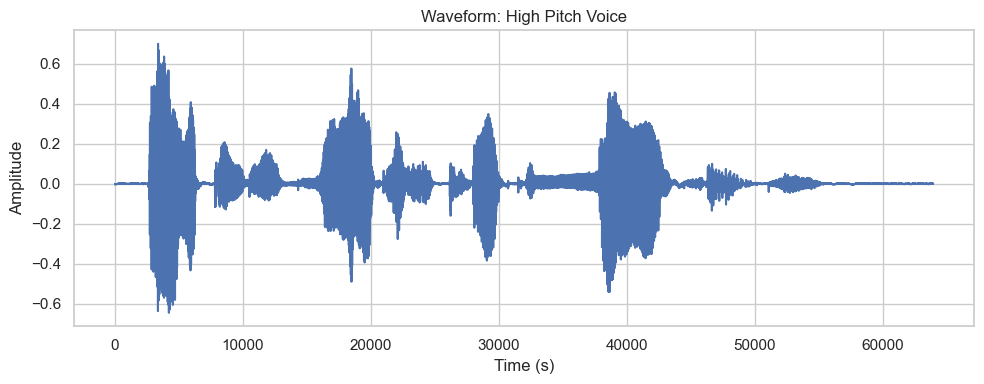

✓ Waveform saved as 'waveform_high_pitch_voice.png'


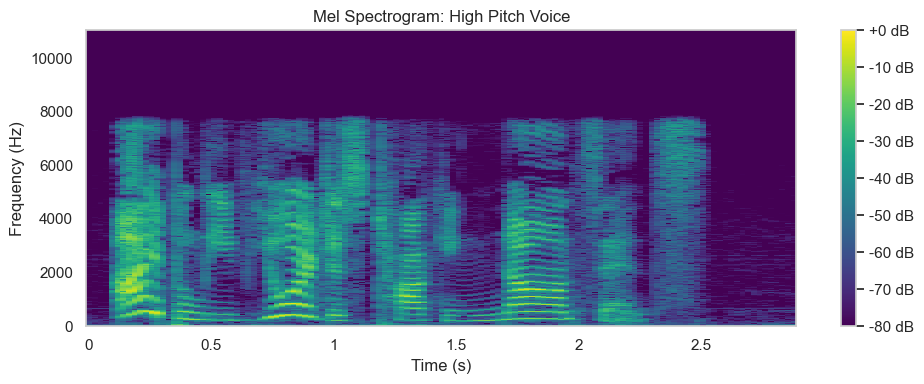

✓ Mel Spectrogram saved as 'spectrogram_high_pitch_voice.png'


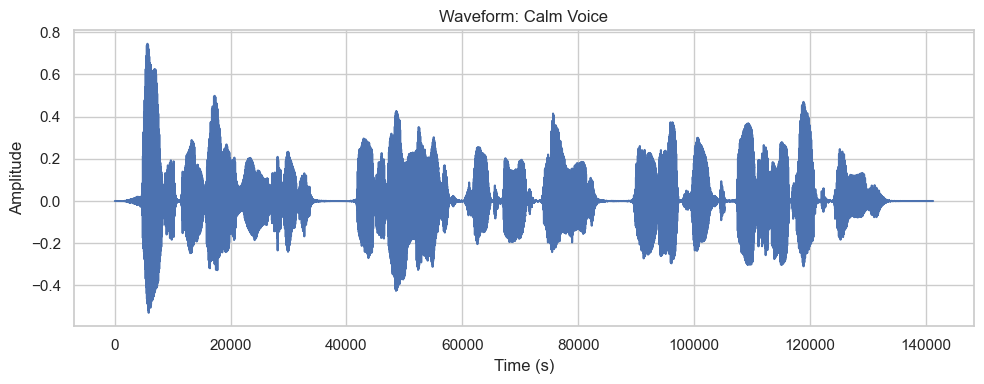

✓ Waveform saved as 'waveform_calm_voice.png'


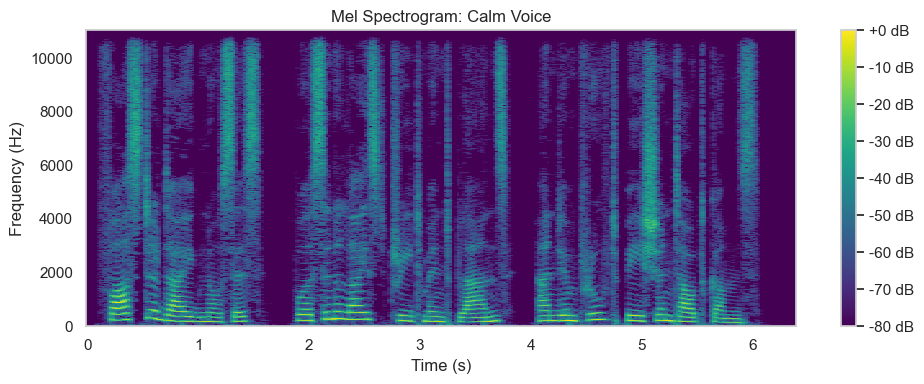

✓ Mel Spectrogram saved as 'spectrogram_calm_voice.png'


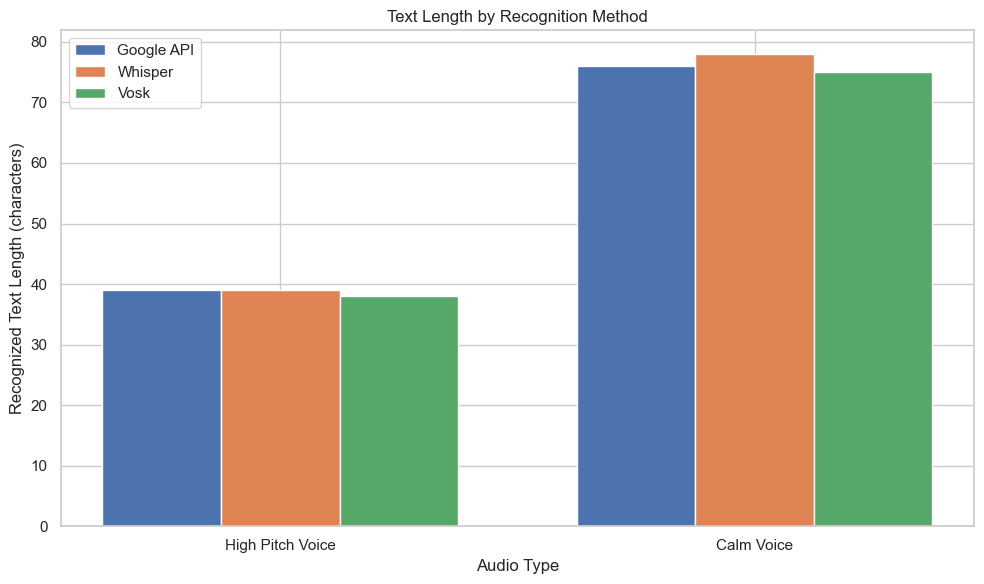

✓ Bar plot saved as 'text_length_comparison.png'


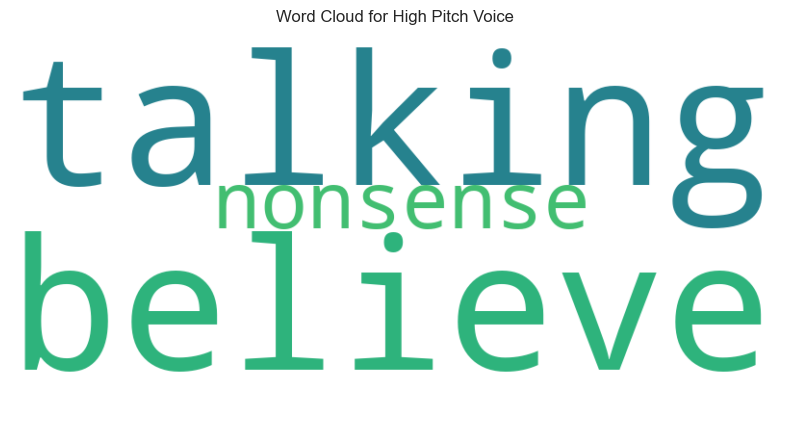

✓ Word cloud saved as 'wordcloud_high_pitch_voice.png'


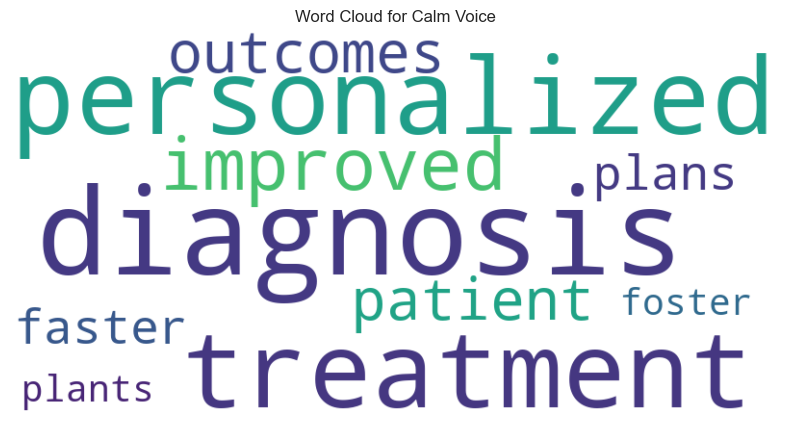

✓ Word cloud saved as 'wordcloud_calm_voice.png'

=== Testing Completed ===


"\nINSTRUCTIONS:\n1. Install dependencies:\n   pip install speechrecognition openai-whisper vosk pyaudio pydub matplotlib wordcloud librosa\n   Download Vosk model: https://alphacephei.com/vosk/models\n   Ensure ffmpeg is installed for pydub (mp3 support)\n\n2. File setup:\n   Ensure high_pitch.wav and calm.mp3 are in the 'audio_files' folder\n   Paths are set to 'audio_files/high_pitch.wav' and 'audio_files/calm.mp3'\n\n3. Running the script:\n   Run to process both audio files, generate comparison table, and display/save visualizations\n   Results saved to 'speech_comparison.csv'\n   Visualizations saved as 'waveform_*.png', 'spectrogram_*.png', 'text_length_comparison.png', and 'wordcloud_*.png'\n   Graphs will display interactively if run in Jupyter or VS Code\n\n4. Troubleshooting:\n   - Check internet for Google API\n   - Verify Vosk model path\n   - Ensure audio_files folder exists with both files\n   - Install ffmpeg for mp3 support\n   - Ensure matplotlib, wordcloud, and libro

In [ ]:
import speech_recognition as sr
import os
import warnings
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import librosa
import librosa.display
warnings.filterwarnings('ignore')

try:
    import whisper
    WHISPER_AVAILABLE = True
    print("✓ Whisper available")
except ImportError:
    WHISPER_AVAILABLE = False
    print("⚠ Whisper not available (install: pip install openai-whisper)")

try:
    from vosk import Model, KaldiRecognizer
    import wave
    import json
    VOSK_AVAILABLE = True
    print("✓ Vosk available")
except ImportError:
    VOSK_AVAILABLE = False
    print("⚠ Vosk not available (install: pip install vosk)")

try:
    from pydub import AudioSegment
    PYDUB_AVAILABLE = True
    print("✓ Pydub available")
except ImportError:
    PYDUB_AVAILABLE = False
    print("⚠ Pydub not available (install: pip install pydub)")

try:
    import matplotlib.pyplot as plt
    import wordcloud
    import librosa
    VISUALIZATION_AVAILABLE = True
    print("✓ Visualization libraries available")
except ImportError:
    VISUALIZATION_AVAILABLE = False
    print("⚠ Visualization libraries not available (install: pip install matplotlib wordcloud librosa)")

class SimpleSpeechToText:
    def __init__(self):
        self.recognizer = sr.Recognizer()
        self.whisper_model = whisper.load_model("base") if WHISPER_AVAILABLE else None
        self.vosk_model_path = "vosk-model-small-en-us-0.15"

    def show_feedback(self, message):
        print(f"ℹ️ {message}")

    def convert_to_wav(self, file_path):
        """Convert mp3 to wav if necessary, return wav path."""
        if not PYDUB_AVAILABLE and file_path.endswith('.mp3'):
            return None, "Error: Pydub required for mp3 files (install: pip install pydub)"
        if file_path.endswith('.wav'):
            return file_path, None
        try:
            audio = AudioSegment.from_mp3(file_path)
            wav_path = file_path.replace('.mp3', '.wav')
            audio.export(wav_path, format='wav')
            return wav_path, None
        except Exception as e:
            return None, f"Error converting mp3 to wav: {e}"

    def load_audio_file(self, file_path):
        self.show_feedback("Loading audio file...")
        try:
            if not os.path.exists(file_path):
                self.show_feedback(f"File not found: {file_path}")
                return None
            if file_path.endswith('.mp3'):
                wav_path, error = self.convert_to_wav(file_path)
                if error:
                    self.show_feedback(error)
                    return None
                file_path = wav_path
            with sr.AudioFile(file_path) as source:
                audio = self.recognizer.record(source)
                self.show_feedback("Audio file loaded")
                return audio
        except Exception as e:
            self.show_feedback(f"Error loading audio: {e}")
            return None

    def google_recognize(self, audio):
        self.show_feedback("Recognizing with Google API...")
        try:
            text = self.recognizer.recognize_google(audio)
            self.show_feedback("Speech successfully converted to text!")
            return f"Speech recognized: '{text}'"
        except sr.UnknownValueError:
            return "Error: Could not understand audio. Please speak clearly."
        except sr.RequestError as e:
            return f"Error: Google API unavailable. Check internet. ({e})"
        except Exception as e:
            return f"Error in Google recognition: {e}"

    def whisper_recognize(self, file_path):
        if not WHISPER_AVAILABLE or not self.whisper_model:
            return "Error: Whisper not available (install: pip install openai-whisper)"
        self.show_feedback("Recognizing with Whisper...")
        try:
            if file_path.endswith('.mp3'):
                file_path, error = self.convert_to_wav(file_path)
                if error:
                    return error
            if not os.path.exists(file_path):
                return "Error: Audio file not found"
            result = self.whisper_model.transcribe(file_path)
            text = result["text"].strip()
            self.show_feedback("Speech successfully converted to text!")
            return f"Speech recognized: '{text}'"
        except Exception as e:
            return f"Error in Whisper recognition: {e}"

    def vosk_recognize(self, file_path):
        if not VOSK_AVAILABLE:
            return "Error: Vosk not available (install: pip install vosk)"
        if not os.path.exists(self.vosk_model_path):
            return "Error: Vosk model not found. Download from https://alphacephei.com/vosk/models"
        self.show_feedback("Recognizing with Vosk...")
        try:
            if file_path.endswith('.mp3'):
                file_path, error = self.convert_to_wav(file_path)
                if error:
                    return error
            wf = wave.open(file_path, "rb")
            if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getcomptype() != "NONE":
                return "Error: Audio must be WAV mono PCM"
            model = Model(self.vosk_model_path)
            rec = KaldiRecognizer(model, wf.getframerate())
            results = []
            while True:
                data = wf.readframes(4000)
                if len(data) == 0:
                    break
                if rec.AcceptWaveform(data):
                    result = json.loads(rec.Result())
                    if 'text' in result:
                        results.append(result['text'])
            final_result = json.loads(rec.FinalResult())
            if 'text' in final_result:
                results.append(final_result['text'])
            text = ' '.join(results).strip()
            wf.close()
            self.show_feedback("Speech successfully converted to text!")
            return f"Speech recognized: '{text}'" if text else "Error: No speech detected"
        except Exception as e:
            return f"Error in Vosk recognition: {e}"

    def process_audio(self, source, source_type='file'):
        results = {'Google API': 'N/A', 'Whisper': 'N/A', 'Vosk': 'N/A'}
        audio_file_path = source if source_type == 'file' else None
        audio_data = self.load_audio_file(source) if source_type == 'file' else source

        print("\n=== Speech Recognition Results ===")
        if audio_data:
            results['Google API'] = self.google_recognize(audio_data)
            print(f"Google API: {results['Google API']}")
        if audio_file_path:
            results['Whisper'] = self.whisper_recognize(audio_file_path)
            print(f"Whisper: {results['Whisper']}")
            results['Vosk'] = self.vosk_recognize(audio_file_path)
            print(f"Vosk: {results['Vosk']}")
        else:
            print("Whisper and Vosk require audio file path")
        print("=================================\n")
        return results

def create_audio_visualizations(file_path, audio_type):
    """Generate waveform and Mel spectrogram for the audio file."""
    if not VISUALIZATION_AVAILABLE:
        print(f"⚠ Cannot generate visualizations for {audio_type}: Install required libraries")
        return

    try:
        # Convert mp3 to wav if necessary
        if file_path.endswith('.mp3'):
            wav_path, error = SimpleSpeechToText().convert_to_wav(file_path)
            if error:
                print(f"⚠ Error converting {audio_type}: {error}")
                return
            file_path = wav_path

        # Load audio file
        y, sr = librosa.load(file_path)
        
        # Waveform
        plt.figure(figsize=(10, 4))
        plt.plot(y)
        plt.title(f"Waveform: {audio_type}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.tight_layout()
        plt.savefig(f'waveform_{audio_type.replace(" ", "_").lower()}.png')
        plt.show()
        print(f"✓ Waveform saved as 'waveform_{audio_type.replace(' ', '_').lower()}.png'")

        # Mel Spectrogram
        plt.figure(figsize=(10, 4))
        D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear', cmap='viridis')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Mel Spectrogram: {audio_type}")
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")
        plt.tight_layout()
        plt.savefig(f'spectrogram_{audio_type.replace(" ", "_").lower()}.png')
        plt.show()
        print(f"✓ Mel Spectrogram saved as 'spectrogram_{audio_type.replace(' ', '_').lower()}.png'")
    except Exception as e:
        print(f"⚠ Error generating audio visualizations for {audio_type}: {e}")

def create_visualizations(comparison_data):
    """Generate and display additional visualizations for comparison data."""
    if not VISUALIZATION_AVAILABLE:
        print("⚠ Cannot generate visualizations: Install matplotlib, wordcloud, and librosa")
        return

    try:
        # Bar Plot: Text length by method and audio type
        methods = ['Google API', 'Whisper', 'Vosk']
        audio_types = [row['Audio Type'] for row in comparison_data]
        lengths = {method: [] for method in methods}
        
        for row in comparison_data:
            for method in methods:
                text = row[method]
                length = len(text.replace("Speech recognized: ", "").strip("'")) if text.startswith("Speech recognized") else 0
                lengths[method].append(length)
        
        plt.figure(figsize=(10, 6))
        bar_width = 0.25
        x = range(len(audio_types))
        for i, method in enumerate(methods):
            plt.bar([pos + i * bar_width for pos in x], lengths[method], bar_width, label=method)
        
        plt.xlabel('Audio Type')
        plt.ylabel('Recognized Text Length (characters)')
        plt.title('Text Length by Recognition Method')
        plt.xticks([pos + bar_width for pos in x], audio_types)
        plt.legend()
        plt.tight_layout()
        plt.savefig('text_length_comparison.png')
        plt.show()
        print("✓ Bar plot saved as 'text_length_comparison.png'")

        # Word Cloud: Combined text for each audio type
        for row in comparison_data:
            audio_type = row['Audio Type']
            combined_text = ' '.join([
                row[method].replace("Speech recognized: ", "").strip("'")
                for method in methods if row[method].startswith("Speech recognized")
            ])
            if combined_text.strip():
                wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
                plt.figure(figsize=(10, 5))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis('off')
                plt.title(f"Word Cloud for {audio_type}")
                plt.savefig(f'wordcloud_{audio_type.replace(" ", "_").lower()}.png')
                plt.show()
                print(f"✓ Word cloud saved as 'wordcloud_{audio_type.replace(' ', '_').lower()}.png'")
            else:
                print(f"⚠ No valid text for word cloud: {audio_type}")
    except Exception as e:
        print(f"⚠ Error generating visualizations: {e}")

def create_comparison_table():
    import pandas as pd
    test_scenarios = {
        'High Pitch Voice': 'audio_files/high_pitch.wav',
        'Calm Voice': 'audio_files/calm.mp3'
    }
    comparison_data = []
    stt = SimpleSpeechToText()
    
    for audio_type, file_path in test_scenarios.items():
        print(f"\nTesting: {audio_type}")
        results = stt.process_audio(file_path, source_type='file')
        comparison_data.append({
            'Audio Type': audio_type,
            'Google API': results['Google API'],
            'Whisper': results['Whisper'],
            'Vosk': results['Vosk'],
            'Notes': ''
        })
    
    df = pd.DataFrame(comparison_data)
    print("\n=== Comparison Table ===")
    print(df.to_string(index=False, col_space={'Audio Type': 15, 'Google API': 40, 'Whisper': 40, 'Vosk': 40, 'Notes': 20}, justify='left'))
    df.to_csv('speech_comparison.csv', index=False)
    print("✓ Table saved to 'speech_comparison.csv'")
    
    # Generate audio visualizations
    for audio_type, file_path in test_scenarios.items():
        create_audio_visualizations(file_path, audio_type)
    
    # Generate additional visualizations
    create_visualizations(comparison_data)
    return df

if __name__ == "__main__":
    print("\n=== Speech-to-Text System ===")
    create_comparison_table()
    print("\n=== Testing Completed ===")



In [ ]:
pd.read_csv("speech_comparison.csv")

,Audio Type,Google API,Whisper,Vosk
High Pitch Voice,Speech recognized: 'I believe you are just tal...,Speech recognized: 'I believe you're just talk...,Speech recognized: 'i believe you're just talk...,NaN
Calm Voice,Speech recognized: 'faster diagnosis personali...,"Speech recognized: 'faster diagnosis, personal...",Speech recognized: 'foster diagnosis personali...,NaN
